In [117]:
import numpy as np
import matplotlib.pyplot as plt

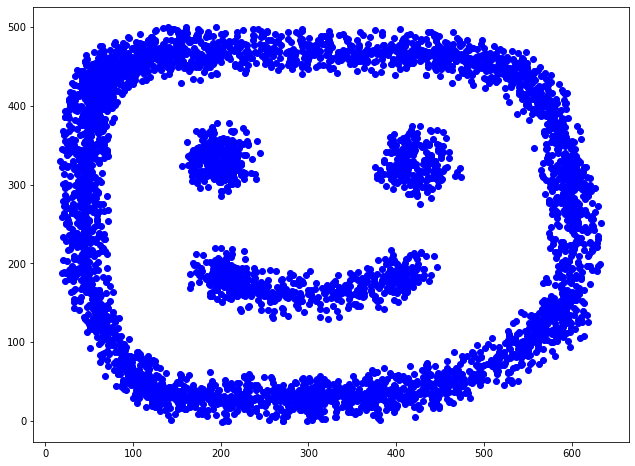

In [329]:
import pygame

points = np.empty((0,2), dtype='f')
    
c_radius = 2
c_color = (0,0,255)
c_thickness = 0 
jet_radius = 30
jet_thr = 0

bg_color = (255,255,255)
(width,height) = (640,480)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("#5")

running = True
pushing = False
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            pushing = True
        elif event.type == pygame.MOUSEBUTTONUP:
            pushing = False
            
    if pushing and np.random.uniform(0,1)>jet_thr:        
        (x, y) = pygame.mouse.get_pos()
        r = np.random.uniform(0,jet_radius)
        phi = np.random.uniform(0,2*np.pi)
        coord = [x+r*np.cos(phi), height-y+r*np.sin(phi)]
        points = np.append(points, [coord], axis=0)
            
    screen.fill(bg_color)
    for point in points:
        pygame.draw.circle(screen,c_color,(int(point[0]),height-int(point[1])),c_radius,c_thickness)
    pygame.display.flip()
    
pygame.quit()

fig = plt.figure(figsize=(width/60,height/60))
plt.scatter(points[:,0],points[:,1],c="blue")
plt.show()

In [330]:
class DB_SCAN():
    
    def __init__(self, dataset, eps=20.0, min_samples=10):
        self.dataset = dataset
        self.eps = eps
        self.min_samples = min_samples
        self.n_clusters = 0
        self.clusters = {0:[]}
        self.visited = set()
        self.clustered = set()
        self.labels = np.array([], dtype='i')
        self.fitted = False
    
    @staticmethod
    def get_dist(list1, list2):
        return np.sqrt(sum((i-j)**2 for i,j in zip(list1,list2)))
    
    @classmethod
    def get_mean_distances_between_points(cls, dataset, m):
        """
        Вычисление среднего расстояния по m ближайшим соседям для каждой точки
        """
        distances = []
        for data in dataset:
            mean_dist = np.mean(sorted([cls.get_dist(Q, data) for Q in dataset if (Q!=data).all()])[:m])
            distances.append(mean_dist)
        distances = np.array(sorted(distances))
        return distances
    
    @classmethod
    def get_recommend_eps_by_diff(cls, dataset, m):
        """
        Начиная со 2 точки, вычисляем разность между текущим значением и предыдущим
        """
        distances = cls.get_mean_distances_between_points(dataset, m)
        diffs = np.array([distances[i]-distances[i-1] for i in range(1, len(distances))])
        return distances[diffs.argmax()+1]
        
    
    @classmethod
    def get_recommend_eps_by_curve(cls, dataset, m):
        """
        Перебираем все точки с расстоянием, начиная со 2 точки;
        в качестве радиуса кривизны траектории в данной точке возьмем радиус окружности,
        проходящей через эту точку, предыдущую и последующую. 
        Если эти 3 точки лежат на одной прямой, то возьмем R=∞(большое число)
        """
        distances = cls.get_mean_distances_between_points(dataset, m)
        # считаем длину отрезка, проходящего через 2 точки
        get_length = lambda x1, x2: np.sqrt((x2 - x1)*(x2 - x1) + (distances[x2]-distances[x1])*(distances[x2]-distances[x1]))
        radius_of_curvature = []
        
        for i in range(1, len(distances)-1):
            x1 = i-1
            x2 = i
            x3 = i+1
            # проверяем находятся ли 3 точки на одной прямой
            if ((x3 - x1) / (x2 - x1) == (distances[x3] - distances[x1]) / (distances[x2] - distances[x1])):
                # если три точки лежат на одной прямой добавляем большое число
                radius_of_curvature.append(distances.max()+1e7)
            else:
                # иначе считаем радиус кривизны, как радиус окружности описанной около треугольника из 3 соседних точек
                a = get_length(x2, x1)
                b = get_length(x3, x2)
                c = get_length(x3, x1)
                p = (a+b+c)/2
                S = np.sqrt(p*(p - a)*(p - b)*(p - c))
                R = a*b*c / (4*S)
                radius_of_curvature.append(R)
        # чем меньше радиус кривизны, тем больше выпуклость
        return distances[np.array(radius_of_curvature).argmin()+1]
        
    def fit(self):
        for P in self.dataset:
            P = list(P)
            if tuple(P) in self.visited:
                continue
            self.visited.add(tuple(P))
            neighbours = self.get_neighbours(P)
            if len(neighbours) < self.min_samples:
                self.clusters[0].append(P)
            else:
                self.expand_cluster(P)
        self.fitted = True
            
    def get_neighbours(self, P):
        return [list(Q) for Q in self.dataset \
                if self.get_dist(Q,P) < self.eps]
    
    def expand_cluster(self, P):
        self.n_clusters += 1
        self.clusters[self.n_clusters] = [P]
        self.clustered.add(tuple(P))
        neighbours = self.get_neighbours(P)
        while neighbours:
            Q = neighbours.pop()
            if tuple(Q) not in self.visited:
                self.visited.add(tuple(Q))
                Q_neighbours = self.get_neighbours(Q)
                if len(Q_neighbours) > self.min_samples:
                    neighbours.extend(Q_neighbours)
            if tuple(Q) not in self.clustered:
                self.clustered.add(tuple(Q))
                self.clusters[self.n_clusters].append(Q)
                if Q in self.clusters[0]:
                    self.clusters[0].remove(Q)
        
    def get_labels(self):
        labels = []
        if not self.fitted:
            self.fit()
        for P in self.dataset:
            for i in range(self.n_clusters+1):
                if list(P) in self.clusters[i]:
                    labels.append(i)
        self.labels = np.array(labels, dtype='i')
        return self.labels

In [331]:
distances = DB_SCAN.get_mean_distances_between_points(points, 5)

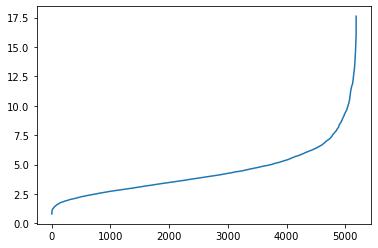

In [332]:
plt.plot(distances) 
plt.show()

In [333]:
eps = DB_SCAN.get_recommend_eps_by_diff(points, 5)
eps2 = DB_SCAN.get_recommend_eps_by_curve(points, 5)

In [334]:
eps, eps2

(17.60768555916445, 15.840600858178613)

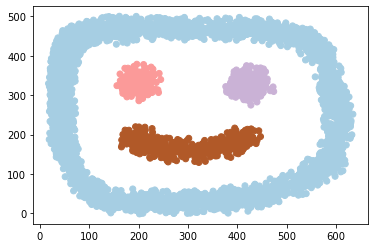

In [335]:
dbscan = DB_SCAN(points, eps=eps, min_samples=5)
labels = dbscan.get_labels()

plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()

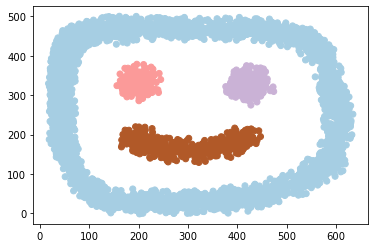

In [336]:
dbscan = DB_SCAN(points, eps=eps2, min_samples=5)
labels = dbscan.get_labels()

plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()

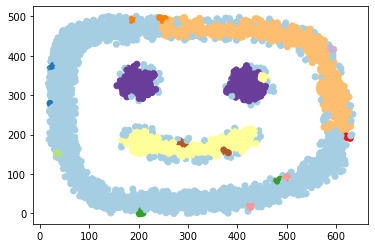

In [337]:
dbscan = DB_SCAN(points, eps=8.5, min_samples=5)
labels = dbscan.get_labels()

plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()

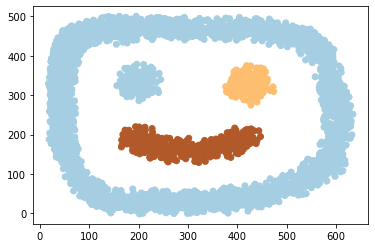

In [339]:
dbscan = DB_SCAN(points, eps=60, min_samples=5)
labels = dbscan.get_labels()

plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()